In [1]:
import sys
sys.path.append("../")

from torch import nn
from data_utils import load_mnist, load_usps
from models import DomainAdaptationNetwork

import torch
from torch.nn import functional as F
import numpy as np
from train import train_domain_adaptation
from utils import test_network, plot_target_cross_domain_swapping, plot_tsne

In [2]:
torch.manual_seed(0)
import numpy as np
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_space_dim, conv_feat_size, nb_channels=3):
        super(Decoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.conv_feat_size = conv_feat_size

        self.deco_dense = nn.Sequential(
            nn.Linear(in_features=latent_space_dim, out_features=1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features=np.prod(self.conv_feat_size)),
            nn.ReLU(True),
        )

        self.deco_fetures = nn.Sequential(
            nn.Conv2d(in_channels=self.conv_feat_size[0], out_channels=75, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=75, out_channels=50, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=50, out_channels=1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, z_share, z_spe):
        z = torch.cat([z_share, z_spe], 1)
        feat_encode = self.deco_dense(z)
        feat_encode = feat_encode.view(-1, *self.conv_feat_size)
        y = self.deco_fetures(feat_encode)

        return y


class Encoder(nn.Module):
    def __init__(self, latent_space_dim, img_size, nb_channels=3):
        super(Encoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.nb_channels = nb_channels

        self.conv_feat = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=50, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=50, out_channels=75, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.BatchNorm2d(75),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=75, out_channels=100, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(100),
        )

        self.conv_feat_size = self.conv_feat(torch.zeros(1, *img_size)).shape[1:]
        self.dense_feature_size = np.prod(self.conv_feat_size)

        self.dense_feat = nn.Sequential(
            nn.Linear(in_features=self.dense_feature_size, out_features=1024),
            nn.ReLU(True), )

        self.share_feat = nn.Sequential(
            nn.Linear(in_features=1024, out_features=latent_space_dim),
            nn.ReLU(True),
        )

        self.source_feat = nn.Sequential(
            nn.Linear(in_features=1024, out_features=latent_space_dim),
            nn.ReLU(True),
        )

        self.target_feat = nn.Sequential(
            nn.Linear(in_features=1024, out_features=latent_space_dim),
            nn.ReLU(True),
        )

    def forward(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_share = self.share_feat(feat)
        z_source = self.source_feat(feat)
        z_target = self.target_feat(feat)
        return z_share, z_source, z_target

    def forward_share(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_share = self.share_feat(feat)
        return z_share

    def forward_source(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_source = self.source_feat(feat)
        return z_source

    def forward_target(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_target = self.target_feat(feat)
        return z_target


In [4]:
learning_rate = 5e-4

source_train_loader, source_test_loader = load_mnist(img_size=32, augment=True, batch_size=64, shuffle=True, num_workers=2) 
target_train_loader, target_test_loader = load_usps(img_size=32, augment=True, batch_size=64, shuffle=True, num_workers=2)

encoder = Encoder(latent_space_dim=150, img_size=(1,32,32), nb_channels=1)

conv_feat_size = encoder.conv_feat_size
decoder_source = Decoder(latent_space_dim=300, conv_feat_size=conv_feat_size, nb_channels=1)
decoder_target = Decoder(latent_space_dim=300, conv_feat_size=conv_feat_size, nb_channels=1)

classifier = nn.Sequential(nn.Dropout2d(),
                         nn.Linear(in_features=150, out_features=10),
                         nn.LogSoftmax())

model = DomainAdaptationNetwork(encoder, decoder_source, decoder_target, classifier).cuda()

optimizer = torch.optim.RMSprop([
    {'params': model.encoder.parameters()},
    {'params': model.decoder_source.parameters()},
    {'params': model.decoder_target.parameters()},
    {'params': model.classifier.parameters()},
    {'params': model.spe_predictor.parameters()},
    {'params': model.share_predictor.parameters()}], lr=learning_rate, weight_decay=0.001)

epochs = 50
betas = np.linspace(0, 5, epochs)

train_domain_adaptation(model, optimizer, source_train_loader, target_train_loader,
                                            epochs=50, betas=betas, gamma=0.5, delta=0.5)

  0%|          | 0/50 [00:00<?, ?it/s]/home/david/anaconda3/envs/domain_adaptation/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
epoch:0 current target accuracy:54.93%:   2%|▏         | 1/50 [00:09<07:23,  9.06s/it]

epoch [1/50], loss:0.3983
accuracy source: 67.87%
accuracy target: 54.97%


epoch:1 current target accuracy:77.95%:   4%|▍         | 2/50 [00:17<07:12,  9.01s/it]

epoch [2/50], loss:0.1745
accuracy source: 94.07%
accuracy target: 78.0%


epoch:2 current target accuracy:83.18%:   6%|▌         | 3/50 [00:26<07:01,  8.96s/it]

epoch [3/50], loss:0.1459
accuracy source: 95.92%
accuracy target: 83.24%


epoch:3 current target accuracy:89.05%:   8%|▊         | 4/50 [00:35<06:51,  8.94s/it]

epoch [4/50], loss:0.1373
accuracy source: 96.5%
accuracy target: 89.11%


epoch:4 current target accuracy:90.06%:  10%|█         | 5/50 [00:44<06:42,  8.93s/it]

epoch [5/50], loss:0.1306
accuracy source: 96.74%
accuracy target: 90.12%


epoch:5 current target accuracy:91.39%:  12%|█▏        | 6/50 [00:53<06:33,  8.95s/it]

epoch [6/50], loss:0.1238
accuracy source: 97.45%
accuracy target: 91.46%


epoch:6 current target accuracy:94.04%:  14%|█▍        | 7/50 [01:02<06:25,  8.97s/it]

epoch [7/50], loss:0.1210
accuracy source: 97.63%
accuracy target: 94.1%


epoch:7 current target accuracy:92.91%:  16%|█▌        | 8/50 [01:11<06:17,  8.98s/it]

epoch [8/50], loss:0.1190
accuracy source: 97.52%
accuracy target: 92.98%


epoch:8 current target accuracy:93.63%:  18%|█▊        | 9/50 [01:20<06:09,  9.00s/it]

epoch [9/50], loss:0.1194
accuracy source: 97.4%
accuracy target: 93.69%


epoch:9 current target accuracy:94.5%:  20%|██        | 10/50 [01:30<06:04,  9.12s/it]

epoch [10/50], loss:0.1115
accuracy source: 98.01%
accuracy target: 94.57%


epoch:10 current target accuracy:95.27%:  22%|██▏       | 11/50 [01:39<05:58,  9.19s/it]

epoch [11/50], loss:0.1076
accuracy source: 98.0%
accuracy target: 95.34%


epoch:11 current target accuracy:95.18%:  24%|██▍       | 12/50 [01:48<05:51,  9.25s/it]

epoch [12/50], loss:0.1087
accuracy source: 98.12%
accuracy target: 95.24%


epoch:12 current target accuracy:95.56%:  26%|██▌       | 13/50 [01:57<05:39,  9.17s/it]

epoch [13/50], loss:0.1042
accuracy source: 98.25%
accuracy target: 95.62%


epoch:13 current target accuracy:94.64%:  28%|██▊       | 14/50 [02:06<05:29,  9.15s/it]

epoch [14/50], loss:0.1023
accuracy source: 98.37%
accuracy target: 94.71%


epoch:14 current target accuracy:95.27%:  30%|███       | 15/50 [02:16<05:25,  9.30s/it]

epoch [15/50], loss:0.1023
accuracy source: 98.12%
accuracy target: 95.34%


epoch:15 current target accuracy:94.82%:  32%|███▏      | 16/50 [02:25<05:13,  9.21s/it]

epoch [16/50], loss:0.1023
accuracy source: 98.0%
accuracy target: 94.88%


epoch:16 current target accuracy:94.7%:  34%|███▍      | 17/50 [02:34<05:05,  9.27s/it] 

epoch [17/50], loss:0.1012
accuracy source: 98.44%
accuracy target: 94.76%


epoch:17 current target accuracy:94.65%:  36%|███▌      | 18/50 [02:44<04:58,  9.33s/it]

epoch [18/50], loss:0.0974
accuracy source: 98.42%
accuracy target: 94.72%


epoch:18 current target accuracy:94.02%:  38%|███▊      | 19/50 [02:53<04:45,  9.22s/it]

epoch [19/50], loss:0.0994
accuracy source: 98.29%
accuracy target: 94.09%


epoch:19 current target accuracy:93.56%:  40%|████      | 20/50 [03:02<04:39,  9.32s/it]

epoch [20/50], loss:0.0984
accuracy source: 98.33%
accuracy target: 93.62%


epoch:20 current target accuracy:93.54%:  42%|████▏     | 21/50 [03:11<04:27,  9.21s/it]

epoch [21/50], loss:0.0959
accuracy source: 98.55%
accuracy target: 93.61%


epoch:21 current target accuracy:92.76%:  44%|████▍     | 22/50 [03:21<04:21,  9.33s/it]

epoch [22/50], loss:0.0972
accuracy source: 98.38%
accuracy target: 92.83%


epoch:22 current target accuracy:92.97%:  46%|████▌     | 23/50 [03:30<04:09,  9.22s/it]

epoch [23/50], loss:0.0958
accuracy source: 98.45%
accuracy target: 93.03%


epoch:23 current target accuracy:93.42%:  48%|████▊     | 24/50 [03:40<04:03,  9.36s/it]

epoch [24/50], loss:0.0934
accuracy source: 98.86%
accuracy target: 93.49%


epoch:24 current target accuracy:93.71%:  50%|█████     | 25/50 [03:49<03:55,  9.41s/it]

epoch [25/50], loss:0.0931
accuracy source: 98.74%
accuracy target: 93.77%


epoch:25 current target accuracy:93.53%:  52%|█████▏    | 26/50 [03:59<03:47,  9.48s/it]

epoch [26/50], loss:0.0919
accuracy source: 98.75%
accuracy target: 93.59%


epoch:26 current target accuracy:92.65%:  54%|█████▍    | 27/50 [04:09<03:41,  9.65s/it]

epoch [27/50], loss:0.0914
accuracy source: 98.75%
accuracy target: 92.72%


epoch:27 current target accuracy:92.58%:  56%|█████▌    | 28/50 [04:19<03:32,  9.65s/it]

epoch [28/50], loss:0.0930
accuracy source: 98.56%
accuracy target: 92.65%


epoch:28 current target accuracy:92.54%:  58%|█████▊    | 29/50 [04:28<03:22,  9.63s/it]

epoch [29/50], loss:0.0923
accuracy source: 98.66%
accuracy target: 92.61%


epoch:29 current target accuracy:92.38%:  60%|██████    | 30/50 [04:38<03:13,  9.68s/it]

epoch [30/50], loss:0.0907
accuracy source: 98.68%
accuracy target: 92.44%


epoch:30 current target accuracy:93.3%:  62%|██████▏   | 31/50 [04:47<03:02,  9.59s/it] 

epoch [31/50], loss:0.0895
accuracy source: 98.77%
accuracy target: 93.36%


epoch:31 current target accuracy:94.07%:  64%|██████▍   | 32/50 [04:57<02:52,  9.57s/it]

epoch [32/50], loss:0.0896
accuracy source: 98.71%
accuracy target: 94.13%


epoch:32 current target accuracy:93.91%:  66%|██████▌   | 33/50 [05:06<02:41,  9.53s/it]

epoch [33/50], loss:0.0902
accuracy source: 98.67%
accuracy target: 93.98%


epoch:33 current target accuracy:94.59%:  68%|██████▊   | 34/50 [05:16<02:34,  9.66s/it]

epoch [34/50], loss:0.0894
accuracy source: 98.83%
accuracy target: 94.65%


epoch:34 current target accuracy:95.45%:  70%|███████   | 35/50 [05:26<02:24,  9.63s/it]

epoch [35/50], loss:0.0886
accuracy source: 98.67%
accuracy target: 95.52%


epoch:35 current target accuracy:95.93%:  72%|███████▏  | 36/50 [05:35<02:13,  9.55s/it]

epoch [36/50], loss:0.0881
accuracy source: 98.79%
accuracy target: 96.0%


epoch:36 current target accuracy:96.55%:  74%|███████▍  | 37/50 [05:45<02:05,  9.65s/it]

epoch [37/50], loss:0.0869
accuracy source: 98.94%
accuracy target: 96.61%


epoch:37 current target accuracy:96.57%:  76%|███████▌  | 38/50 [05:55<01:55,  9.62s/it]

epoch [38/50], loss:0.0893
accuracy source: 98.75%
accuracy target: 96.64%


epoch:38 current target accuracy:95.72%:  78%|███████▊  | 39/50 [06:04<01:44,  9.53s/it]

epoch [39/50], loss:0.0888
accuracy source: 98.75%
accuracy target: 95.79%


epoch:39 current target accuracy:95.83%:  80%|████████  | 40/50 [06:13<01:34,  9.49s/it]

epoch [40/50], loss:0.0885
accuracy source: 98.78%
accuracy target: 95.9%


epoch:40 current target accuracy:96.2%:  82%|████████▏ | 41/50 [06:23<01:25,  9.53s/it] 

epoch [41/50], loss:0.0868
accuracy source: 98.86%
accuracy target: 96.27%


epoch:41 current target accuracy:95.98%:  84%|████████▍ | 42/50 [06:32<01:15,  9.43s/it]

epoch [42/50], loss:0.0871
accuracy source: 98.73%
accuracy target: 96.05%


epoch:42 current target accuracy:96.03%:  86%|████████▌ | 43/50 [06:41<01:05,  9.39s/it]

epoch [43/50], loss:0.0859
accuracy source: 98.88%
accuracy target: 96.09%


epoch:43 current target accuracy:96.34%:  88%|████████▊ | 44/50 [06:51<00:57,  9.52s/it]

epoch [44/50], loss:0.0862
accuracy source: 98.9%
accuracy target: 96.41%


epoch:44 current target accuracy:96.46%:  90%|█████████ | 45/50 [07:01<00:48,  9.66s/it]

epoch [45/50], loss:0.0833
accuracy source: 99.12%
accuracy target: 96.53%


epoch:45 current target accuracy:97.09%:  92%|█████████▏| 46/50 [07:11<00:38,  9.61s/it]

epoch [46/50], loss:0.0855
accuracy source: 98.83%
accuracy target: 97.16%


epoch:46 current target accuracy:97.46%:  94%|█████████▍| 47/50 [07:20<00:28,  9.61s/it]

epoch [47/50], loss:0.0864
accuracy source: 98.71%
accuracy target: 97.53%


epoch:47 current target accuracy:97.64%:  96%|█████████▌| 48/50 [07:30<00:19,  9.69s/it]

epoch [48/50], loss:0.0845
accuracy source: 99.12%
accuracy target: 97.71%


epoch:48 current target accuracy:98.12%:  98%|█████████▊| 49/50 [07:40<00:09,  9.60s/it]

epoch [49/50], loss:0.0832
accuracy source: 98.9%
accuracy target: 98.19%


epoch:49 current target accuracy:97.94%: 100%|██████████| 50/50 [07:49<00:00,  9.39s/it]

epoch [50/50], loss:0.0863
accuracy source: 98.85%
accuracy target: 98.01%


In [5]:
model.eval()
test_network(model, target_test_loader)  

0.9895761898230695

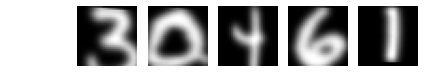

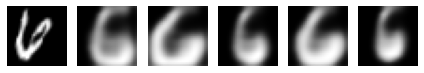

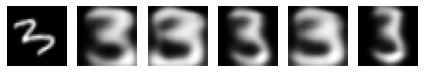

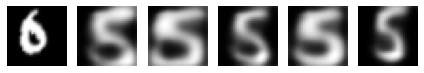

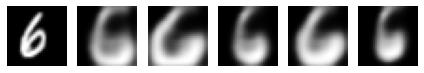

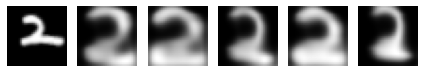

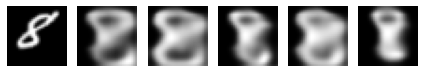

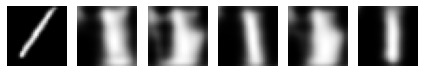

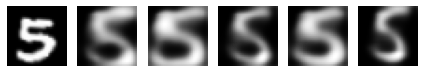

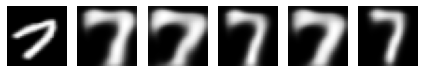

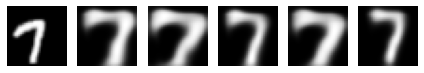

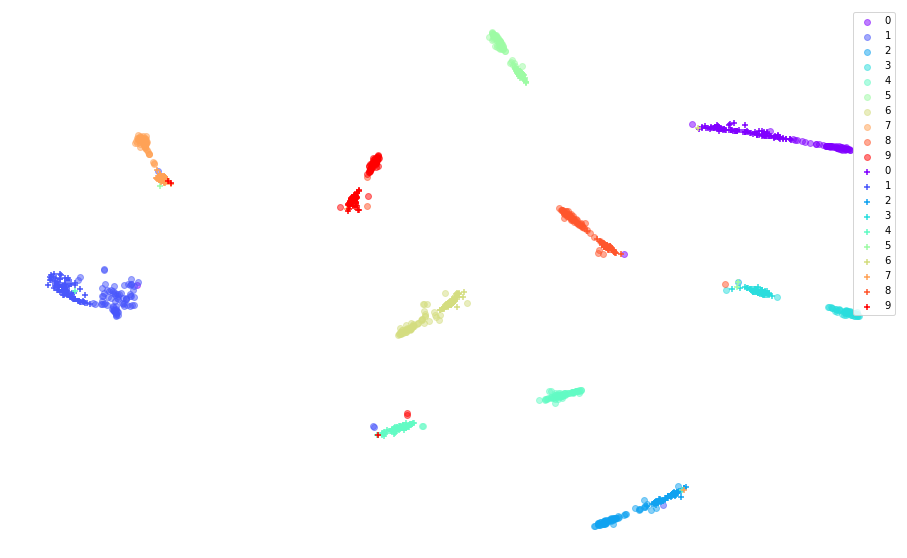

In [6]:
plot_target_cross_domain_swapping(model, source_train_loader, target_train_loader)
plot_tsne(model, source_train_loader, target_train_loader, batch_size=64, feature_size=150)

In [7]:
torch.save(model, "mnist_to_usps.pth")

/home/david/anaconda3/envs/domain_adaptation/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/david/anaconda3/envs/domain_adaptation/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
